# MIE 2021 - DATA REPRESENTATIONS

### TODO:
----------------------
- [x] Time Domain [PPGnet](https://ieeexplore.ieee.org/abstract/document/8856989)
----------------------   
- [x] Time-frequency Spectra [Deep PPG/SPAMA](https://www.mdpi.com/1424-8220/19/14/3079)
----------------------
- [ ] Correlation & FFT [Schäck](https://ieeexplore.ieee.org/abstract/document/8081656)
    - [ ] FIR Filter
    - [ ] Harmonic Noise Dampening
----------------------
- [ ] Singular Value Decomposition [GALLI](https://ieeexplore.ieee.org/document/7969715)
----------------------
- [ ] EEMD-PCA [ABDUL MOTIN](https://ieeexplore.ieee.org/document/7591560)

In [1]:
import scipy 
from scipy import linalg
from scipy import signal
from scipy import stats
import numpy as np
import more_itertools
from PyEMD import EEMD
from sklearn.decomposition import PCA
from sklearn import preprocessing
import os
import pickle5 as pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
%matplotlib inline
import math as maths

In [2]:
#--- HELPER FUNCTIONS ---
#-----------------------------
#windows Function: - splits signal into sliding windows 
    #INP: iterable - signal, n-lengthof window, m-slide
    #OUT - List of sliding windows
def slidingWindow(sequence,winSize,step=1):
    """Returns a generator that will iterate through the defined chunks of input sequence. Input sequence must be sliceable."""

    # Verify the inputs
    if not ((type(winSize) == type(0)) and (type(step) == type(0))):
        raise Exception("**ERROR** type(winSize) and type(step) must be int.")
    if step > winSize:
        raise Exception("**ERROR** step must not be larger than winSize.") 
    if winSize > len(sequence):
        raise Exception("**ERROR** winSize must not be larger than sequence length.")

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,int(numOfChunks)*step,step):
        yield sequence[i:i+winSize]
#-----------------------------
def reshape(lst, n):
    return [lst[i*n:(i+1)*n] for i in range(len(lst)//n)]
#-----------------------------
def load_pickle_file(file):
    infile = open(file,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    return new_dict

def create_pickle(pickle_name, data):
    outfile = open(pickle_name,'wb')
    pickle.dump(data,outfile)
    outfile.close()
    
def resample_signal(signal_data, curr_fs, new_fs):
    num_secs_in_signal = len(signal_data)/curr_fs 
    num_samples_to_resample = round(num_secs_in_signal*new_fs)    # Number of samples to downsample
    return signal.resample(signal_data, num_samples_to_resample)


In [3]:
#--- DATA ---
IEEE_TRAIN = load_pickle_file("IEEE_Train")
IEEE_TEST = load_pickle_file("IEEE_Test")
IEEE_DATA = IEEE_TRAIN + IEEE_TEST

## 1. Time Domain [PPGnet](https://ieeexplore.ieee.org/abstract/document/8856989)
>A. Shyam, V. Ravichandran, S. P. Preejith, J. Joseph and M. Sivaprakasam, "PPGnet: Deep Network for Device Independent Heart Rate Estimation from Photoplethysmogram," 2019 41st Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Berlin, Germany, 2019, pp. 1899-1902, doi: https://doi.org/10.1109/EMBC.2019.8856989.

The input data is segmented into 8 2-second windows. Then split window in 8x 1sec blocks i.e. (8, 125)

In [4]:

time_domain_dataset = []
data_set_truth = []

for sub in range(len(IEEE_DATA)):
    
    for i in slidingWindow(IEEE_DATA[sub]["Raw_PPG_1"], int(8*IEEE_DATA[sub]["PPG_fs"]), int(2*IEEE_DATA[sub]["PPG_fs"])):
        
        p = np.asarray(reshape(i, 8)).T
        time_domain_dataset.append(np.asarray(p))
    
    data_set_truth.append(np.asarray(IEEE_DATA[sub]["truth_values"]))

time_domain_dataset = np.asarray(time_domain_dataset)
time_domain_dataset = np.expand_dims(time_domain_dataset,axis=3)
data_set_truth = np.asarray(data_set_truth)  

data_set_truth = np.asarray([item for sublist in data_set_truth for item in sublist])

print('input data dimension: ',time_domain_dataset.shape)
print('input data label dimension:',data_set_truth.shape)

create_pickle("Time_Domain", time_domain_dataset)

/home/red_dwarf/anaconda3/envs/mie_dataproc/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


input data dimension:  (3096, 8, 125, 1)
input data label dimension: (3096,)


## 2. Time-frequency Spectra [Deep PPG/SPAMA](https://www.mdpi.com/1424-8220/19/14/3079)
>Reiss, A.; Indlekofer, I.; Schmidt, P.; Van Laerhoven, K. Deep PPG: Large-Scale Heart Rate Estimation with Convolutional Neural Networks. Sensors 2019, 19, 3079. https://doi.org/10.3390/s19143079

>Salehizadeh SMA, Dao D, Bolkhovsky J, Cho C, Mendelson Y, Chon KH. A Novel Time-Varying Spectral Filtering Algorithm for Reconstruction of Motion Artifact Corrupted Heart Rate Signals During Intense Physical Activities Using a Wearable Photoplethysmogram Sensor. Sensors. 2016; 16(1):10. https://doi.org/10.3390/s16010010

In [8]:
def specto(sub, sig):
    Y = resample_signal(IEEE_DATA[sub][sig], IEEE_DATA[sub]["PPG_fs"], 64.0)
    freqs, times, spectrogram = signal.spectrogram(
        Y,
        fs=64,
        nperseg =8*64,
        noverlap = 6*64,
        nfft = 16384)
    print(spectrogram[0:1025].shape)
    print("-"*30)
    plt.figure(figsize=(16, 6))
    plt.pcolormesh(times, freqs[0:1025], spectrogram[0:1025], shading='gouraud')
    plt.plot(np.linspace(min(times), max(times), 
                         num=len(IEEE_DATA[sub]["truth_values"])), 
             IEEE_DATA[sub]["truth_values"]/60, label='Truth', 
             color='white', linestyle='-.', alpha=0.6);
    subject = IEEE_DATA[sub]["Subject"]
    dataset = IEEE_DATA[sub]["Dataset"]
    plt.title('Spectrogram of ' + str(dataset)  + ": Subject " + str(subject) + " (" + sig + ")")
    plt.ylabel('Frequency band')
    plt.xlabel('Time window')
    plt.legend()
    plt.show()

In [9]:
def t_freq_dom_represent():
    data_set_sigs = []
    data_set_truth = []
    for sub in range(len(IEEE_DATA)):
        
        ppg_S = []
        acc_x_S = []
        acc_y_S = []
        acc_z_S = []
        labels=[]
        
        ppg_freqs, ppg_times, ppg_Sx = signal.spectrogram(
            resample_signal(IEEE_DATA[sub]["Raw_PPG_1"], IEEE_DATA[sub]["PPG_fs"], 64.0),
            fs=64,
            nperseg =8*64,
            noverlap = 6*64,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 16384)
        acc_x_freqs, acc_x_times, acc_x_Sx = signal.spectrogram(
            resample_signal(IEEE_DATA[sub]["Raw ACC_X"], IEEE_DATA[sub]["PPG_fs"], 64.0),
            fs=64,
            nperseg =8*64,
            noverlap = 6*64,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 16384)
        acc_y_freqs, acc_y_times, acc_y_Sx = signal.spectrogram(
            resample_signal(IEEE_DATA[sub]["Raw ACC_Y"], IEEE_DATA[sub]["PPG_fs"], 64.0),
            fs=64,
            nperseg =8*64,
            noverlap = 6*64,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 16384)
        acc_z_freqs, acc_z_times, acc_z_Sx = signal.spectrogram(
            resample_signal(IEEE_DATA[sub]["Raw ACC_Z"], IEEE_DATA[sub]["PPG_fs"], 64.0),
            fs=64,
            nperseg =8*64,
            noverlap = 6*64,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 16384)

        ppg_S.append(preprocessing.normalize(ppg_Sx[ppg_freqs <= 4]).T)
        acc_x_S.append(preprocessing.normalize(acc_x_Sx[acc_x_freqs <= 4]).T)
        acc_y_S.append(preprocessing.normalize(acc_y_Sx[acc_y_freqs <= 4]).T)
        acc_z_S.append(preprocessing.normalize(acc_z_Sx[acc_z_freqs <= 4]).T)

        ppg_Sx = np.asarray([item for sublist in ppg_S for item in sublist])
        acc_x_Sx = np.asarray([item for sublist in acc_x_S for item in sublist])
        acc_y_Sx = np.asarray([item for sublist in acc_y_S for item in sublist])
        acc_z_Sx = np.asarray([item for sublist in acc_z_S for item in sublist])
        
        sub_data_set = np.dstack((ppg_Sx,acc_x_Sx,acc_y_Sx,acc_z_Sx)) 
        sub_data_set = np.expand_dims(sub_data_set,axis=1)
        sub_data_set_label = IEEE_DATA[sub]["truth_values"]
        
        data_set_sigs.append(sub_data_set)
        data_set_truth.append(sub_data_set_label)
    
    data_set_sigs = np.asarray([item for sublist in data_set_sigs for item in sublist])
    data_set_truth = np.asarray([item for sublist in data_set_truth for item in sublist])
    print('input data dimension: ', data_set_sigs.shape)
    print('input data label dimension:',data_set_truth.shape)

In [10]:
t_freq_dom_represent()

input data dimension:  (3096, 1, 1025, 4)
input data label dimension: (3096,)


(1025, 157)
------------------------------


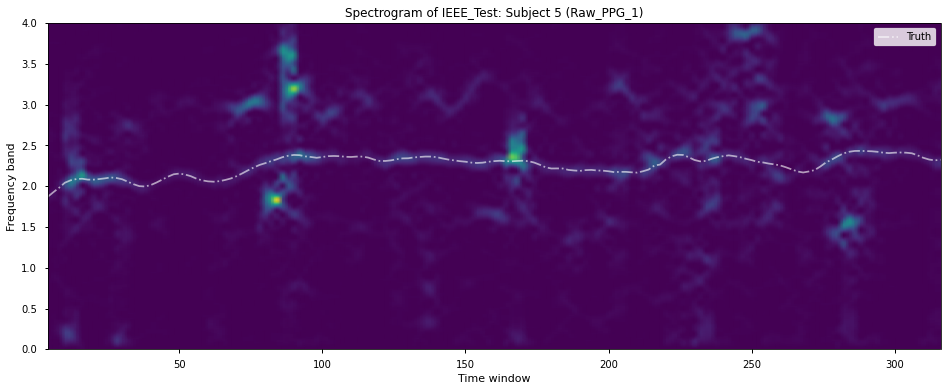

(1025, 157)
------------------------------


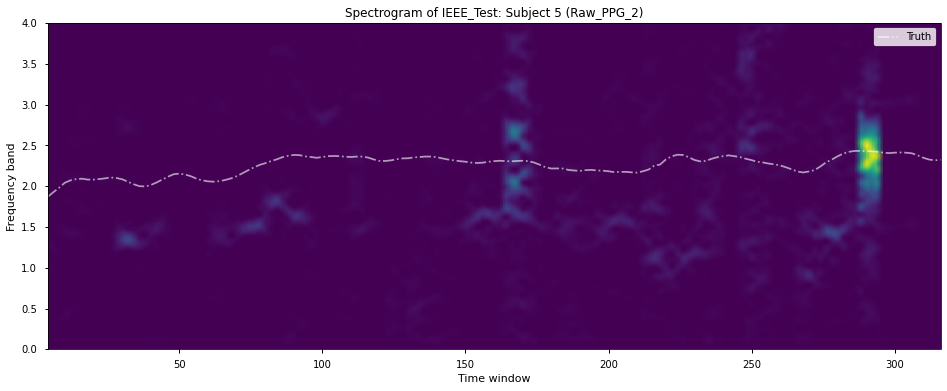

(1025, 157)
------------------------------


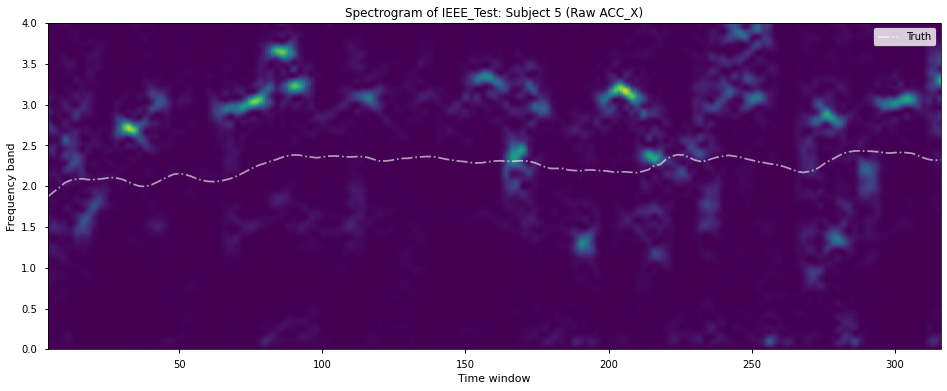

(1025, 157)
------------------------------


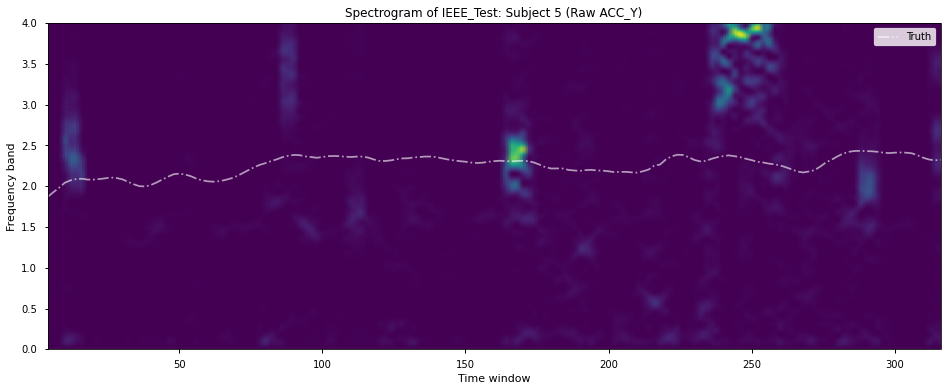

(1025, 157)
------------------------------


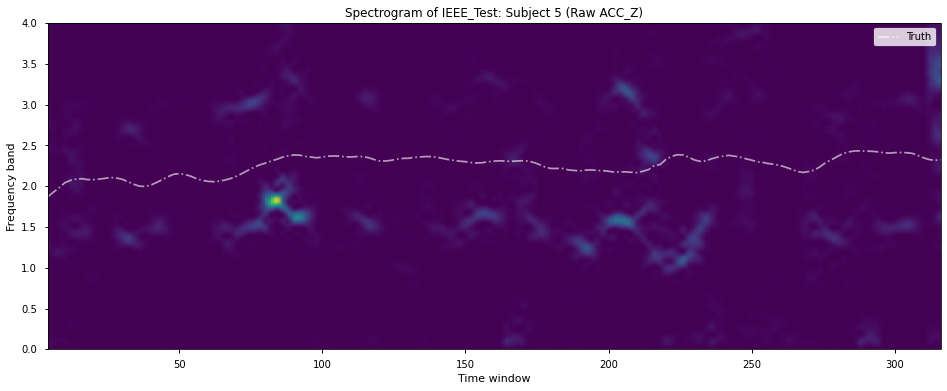

In [11]:
subs = [0, 17, 19]
sigs = ["Raw_PPG_1", "Raw_PPG_2", "Raw ACC_X",  "Raw ACC_Y", "Raw ACC_Z"]
for s in sigs:
    specto(17, s)

## 3. Correlation & FFT [Schäck](https://ieeexplore.ieee.org/abstract/document/8081656)
>T. Schäck, M. Muma and A. M. Zoubir, "Computationally efficient heart rate estimation during physical exercise using photoplethysmographic signals," 2017 25th European Signal Processing Conference (EUSIPCO), Kos, Greece, 2017, pp. 2478-2481, doi: 10.23919/EUSIPCO.2017.8081656.

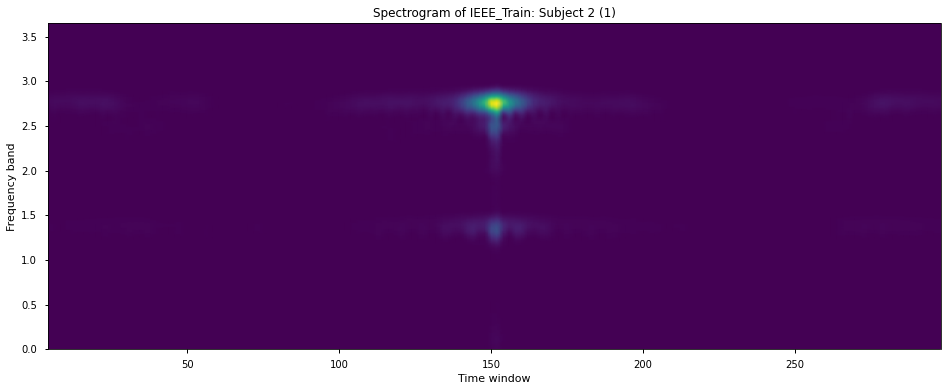

In [67]:
#FIR - (fc1 = 0.5 Hz, fc2 = 6 Hz)
fir_coeff = signal.firwin(12499, cutoff = [0.5, 6], fs=125)

 
# Use lfilter to filter the signal with the FIR filter


#Downsample to 25Hz
downsampled_PPG_1 = resample_signal(IEEE_DATA[1]["Raw_PPG_1"], 125, 25)
downsampled_PPG_2 = resample_signal(IEEE_DATA[1]["Raw_PPG_2"], 125, 25)
downsampled_ACC_X = resample_signal(IEEE_DATA[1]["Raw ACC_X"], 125, 25)
downsampled_ACC_Y = resample_signal(IEEE_DATA[1]["Raw ACC_Y"], 125, 25)
downsampled_ACC_Z = resample_signal(IEEE_DATA[1]["Raw ACC_Z"], 125, 25)

#Cross & Auto Corr - Z-normalise
r_norm_p1_p1 = stats.zscore(np.correlate(downsampled_PPG_1, downsampled_PPG_1, mode='same'))
r_norm_p1_p2 = stats.zscore(np.correlate(downsampled_PPG_1, downsampled_PPG_2, mode='same'))
r_norm_p2_p2 = stats.zscore(np.correlate(downsampled_PPG_2, downsampled_PPG_2, mode='same'))

r_norm_p1_p1_freqs, r_norm_p1_p1_times, r_norm_p1_p1_Sx = signal.spectrogram(
            r_norm_p1_p1,
            fs=25,
            nperseg =8*25,
            noverlap = 6*25,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 2048)
r_norm_p1_p2_freqs, r_norm_p1_p2_times, r_norm_p1_p2_Sx = signal.spectrogram(
            r_norm_p1_p2,
            fs=25,
            nperseg =8*25,
            noverlap = 6*25,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 2048)
r_norm_p2_p2_freqs, r_norm_p2_p2_times, r_norm_p2_p2_Sx = signal.spectrogram(
            r_norm_p2_p2,
            fs=25,
            nperseg =8*25,
            noverlap = 6*25,
            window='hanning',
            detrend=False,
            scaling='spectrum',
            nfft = 2048)

r_norm_Sx = r_norm_p1_p1_Sx + r_norm_p1_p2_Sx + r_norm_p2_p2_Sx

plt.figure(figsize=(16, 6))
plt.pcolormesh(r_norm_p1_p1_times, r_norm_p1_p1_freqs[0:300], r_norm_Sx[0:300], shading='gouraud')
#plt.plot(np.linspace(min(r_norm_p1_p1_times), max(r_norm_p1_p1_times), 
                    # num=len(IEEE_DATA[17]["truth_values"])), 
       # IEEE_DATA[17]["truth_values"]/60, label='Truth', 
        # color='white', linestyle='-.', alpha=0.6);
subject = IEEE_DATA[1]["Subject"]
dataset = IEEE_DATA[1]["Dataset"]
plt.title('Spectrogram of ' + str(dataset)  + ": Subject " + str(subject) + " (1)")
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.show()

## 4. Singular Value Decomposition [GALLI](https://ieeexplore.ieee.org/document/7969715)
>A. Galli, G. Frigo, C. Narduzzi and G. Giorgi, "Robust estimation and tracking of heart rate by PPG signal analysis," 2017 IEEE International Instrumentation and Measurement Technology Conference (I2MTC), Turin, Italy, 2017, pp. 1-6, doi: 10.1109/I2MTC.2017.7969715.

In [11]:
traj_matrix_ppg1 = []
traj_matrix_ppg2 = []
traj_matrix_acc_x = []
traj_matrix_acc_y = []
traj_matrix_acc_z = []
sigs = ["Raw_PPG_1", "Raw_PPG_2", "Raw ACC_X",  "Raw ACC_Y", "Raw ACC_Z"]
traj_matrices = [traj_matrix_ppg1, traj_matrix_ppg2, 
                 traj_matrix_acc_x, traj_matrix_acc_y, traj_matrix_acc_z]
for idx, sig in enumerate(sigs):
    for i in windows(IEEE_DATA[0][sig], 8 * IEEE_DATA[0]["PPG_fs"],2 * IEEE_DATA[0]["PPG_fs"]):
        traj_matrices[idx].append(i)

    
traj_matrix_ppg1 = np.asarray(traj_matrix_ppg1)
traj_matrix_ppg2 = np.asarray(traj_matrix_ppg2)
traj_matrix_acc_x = np.asarray(traj_matrix_acc_x)
traj_matrix_acc_y = np.asarray(traj_matrix_acc_y)
traj_matrix_acc_z = np.asarray(traj_matrix_acc_z)

print(traj_matrix_ppg1.shape)
print(traj_matrix_ppg2.shape)
print(traj_matrix_acc_x.shape)
print(traj_matrix_acc_y.shape)
print(traj_matrix_acc_z.shape)

U_ppg1, s_ppg1, Vh_ppg1 = linalg.svd(traj_matrix_ppg1)
print(U_ppg1.shape,  s_ppg1.shape, Vh_ppg1.shape)
print("-"*30)
U_acc_x, s_acc_x, Vh_acc_x = linalg.svd(traj_matrix_acc_x)
print(U_acc_x.shape,  s_acc_x.shape, Vh_acc_x.shape)
res = np.dot(U_ppg1.T,U_acc_x)
print(res.shape)

(149, 1000)
(149, 1000)
(149, 1000)
(149, 1000)
(149, 1000)
(149, 149) (149,) (1000, 1000)
------------------------------
(149, 149) (149,) (1000, 1000)
(149, 149)


## 4. EEMD-PCA [ABDUL MOTIN](https://ieeexplore.ieee.org/document/7591560)
>M. A. Motin, C. K. Karmakar and M. Palaniswami, "An EEMD-PCA approach to extract heart rate, respiratory rate and respiratory activity from PPG signal," 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Orlando, FL, USA, 2016, pp. 3817-3820, doi: 10.1109/EMBC.2016.7591560.

1. We extracted 45 epochs of simultaneous PPG and respiratory signal, each with a length of 30 seconds.
2. EEMD was applied to the PPG signal for decomposing into true IMFs.
2. Selection of intrinsic mode functions (IMFs) without artifacts
    >Once all dominant frequencies were obtained, IMFs having frequency greater than or equal to 2.5Hz were considered as artifacts and IMFs with frequency less than 2.5 Hz were selected for further processing.
3. PCA of the selected IMFs
    >the PC presenting maximum and second maximum variance will represent the cardiac and respiratory activity respectively

In [12]:
eemd = EEMD(trials=45)
pca = PCA()

In [13]:
def eemd_pca_sub(window, sub):
    for i in reshape(IEEE_DATA[sub]["Raw_PPG_1"], (window*IEEE_DATA[sub]["PPG_fs"])):
        imfs = eemd(i)
        selected_IMFs = []
        for imf in range(len(imfs)):
            fourier_transform = np.fft.rfft(imfs[imf])

            abs_fourier_transform = np.abs(fourier_transform)

            power_spectrum = np.square(abs_fourier_transform)

            frequency = np.linspace(0, IEEE_DATA[sub]["PPG_fs"]/2, len(power_spectrum))

            max_power = np.amax(power_spectrum)
            max_index = np.where(power_spectrum == max_power)

            if float(frequency[max_index]) < 2.5:
                selected_IMFs.append(imfs[imf])

        pca.fit(selected_IMFs)

        fourier_transform = np.fft.rfft(pca.components_[0])

        abs_fourier_transform = np.abs(fourier_transform)

        power_spectrum = np.square(abs_fourier_transform)

        frequency = np.linspace(0, IEEE_DATA[sub]["PPG_fs"]/2, len(power_spectrum))

        max_power = np.amax(power_spectrum)
        max_index = np.where(power_spectrum == max_power)
        print("Computed HR Estimate: ", frequency[max_index]*60)
        print("-"*20)
        per_var = np.round(pca.explained_variance_ratio_ *100, decimals=1)
        labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.title("Explained Variance for PCA on Selected IMFs")
        plt.xlabel("PCAs")
        plt.ylabel("Explained Variance")
        plt.show()
        print("-"*20)
        print()
        plt.figure(figsize=(16, 6))
        plt.plot(i, label='Original Signal')
        plt.plot(pca.components_[0] * 1000, label='PC1')
        #plt.plot(pca.components_[1] * 1000, label='PC2')
        plt.title("Time Domain Comparison of Unfiltered Signal & PCA")
        plt.xlabel("Time (Samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show() 
        break

Computed HR Estimate:  [82.]
--------------------


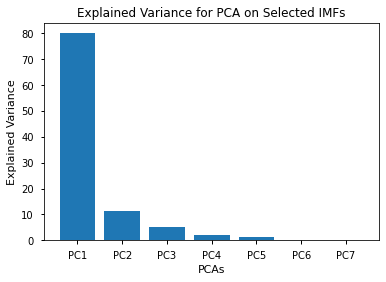

--------------------



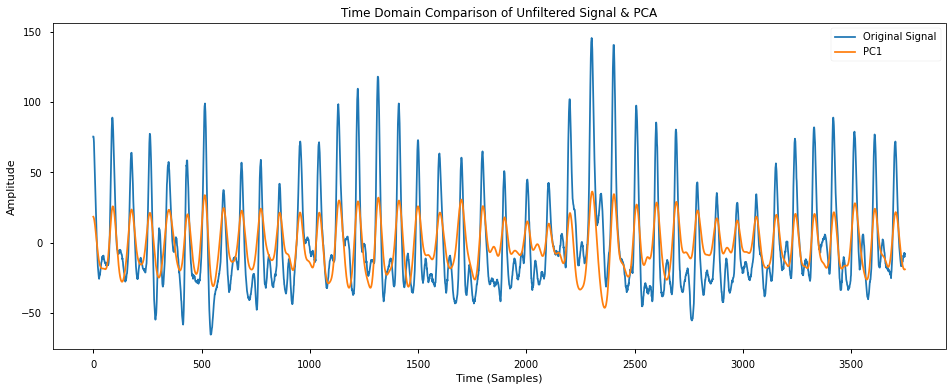

In [14]:
eemd_pca_sub(30, 0)

Computed HR Estimate:  [90.]
--------------------


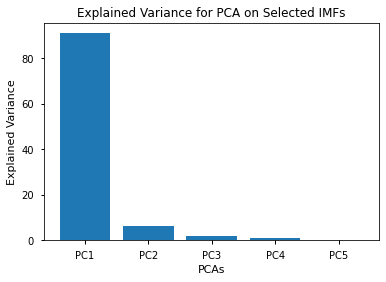

--------------------



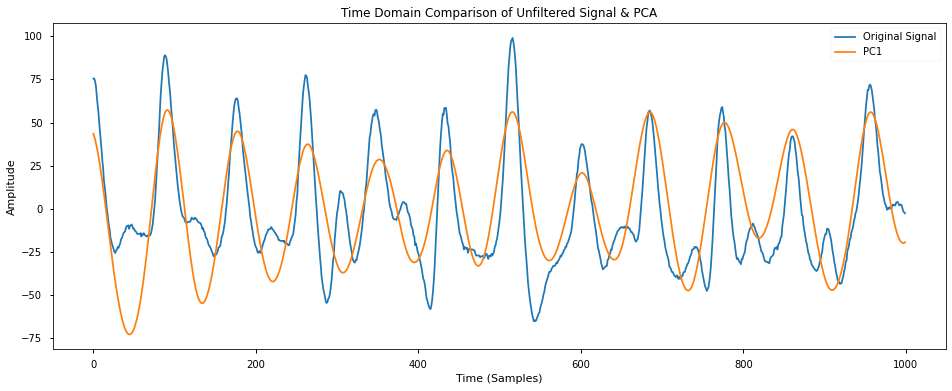

In [15]:
eemd_pca_sub(8, 0)

Computed HR Estimate:  [112.5]
--------------------


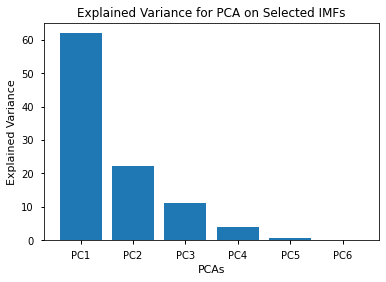

--------------------



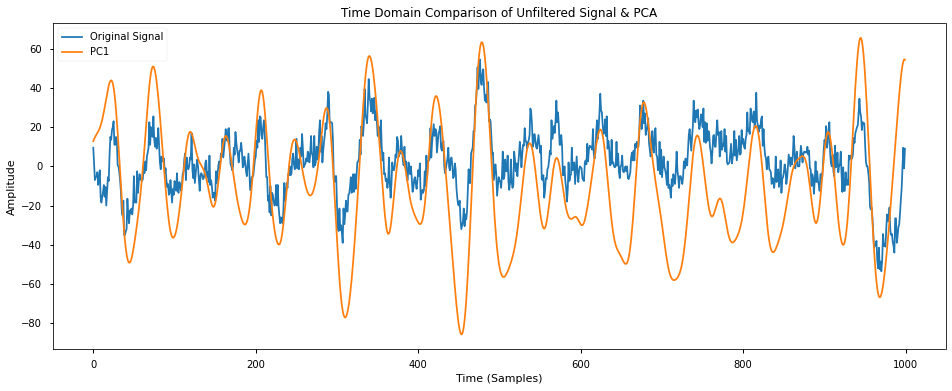

In [48]:
eemd_pca_sub(8, 17)

Computed HR Estimate:  [126.]
--------------------


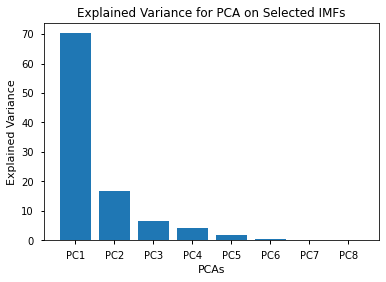

--------------------



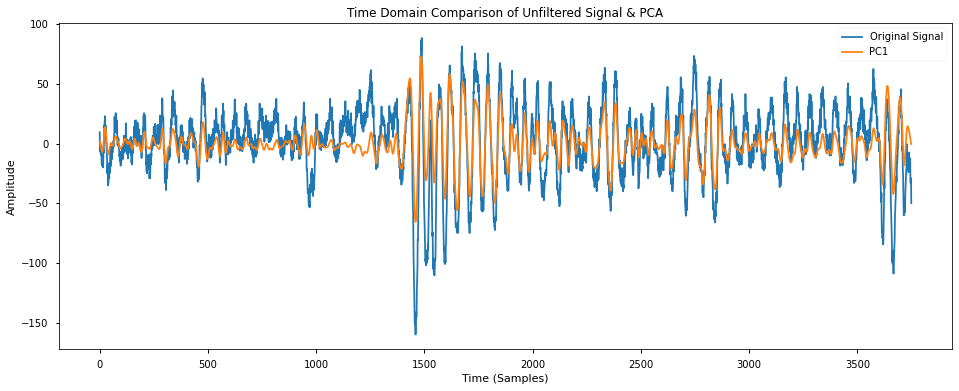

In [49]:
eemd_pca_sub(30, 17)